In [1]:
import numpy as np
from astropy.io import fits
import glob
import os

class MasterFlatGenerator:
    """
    Creates master flat fields for astronomical imaging.
    Handles bias/dark correction, normalization, and combining.
    """
    
    def __init__(self, output_dir='master_flats'):
        """
        Initialize the generator.
        
        Parameters:
        -----------
        output_dir : str
            Directory to save master flats
        """
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        
    def load_frames(self, file_pattern):
        """
        Load multiple FITS frames matching a pattern.
        
        Parameters:
        -----------
        file_pattern : str
            Glob pattern for files (e.g., 'flats/flat_g_*.fits')
            
        Returns:
        --------
        frames : numpy array
            3D array of shape (n_frames, height, width)
        """
        files = sorted(glob.glob(file_pattern))
        if not files:
            raise ValueError(f"No files found matching pattern: {file_pattern}")
        
        frames = []
        for f in files:
            with fits.open(f) as hdul:
                frames.append(hdul[0].data.astype(np.float32))
        
        print(f"Loaded {len(frames)} frames from {file_pattern}")
        return np.array(frames)
    
    def create_master_bias(self, bias_pattern):
        """
        Create master bias by median combining bias frames.
        
        Parameters:
        -----------
        bias_pattern : str
            Glob pattern for bias frames
            
        Returns:
        --------
        master_bias : numpy array
            Master bias frame
        """
        bias_frames = self.load_frames(bias_pattern)
        master_bias = np.median(bias_frames, axis=0)
        print(f"Master bias: median of {len(bias_frames)} frames")
        return master_bias
    
    def create_master_dark(self, dark_pattern, master_bias=None):
        """
        Create master dark by median combining dark frames.
        
        Parameters:
        -----------
        dark_pattern : str
            Glob pattern for dark frames
        master_bias : numpy array, optional
            Master bias to subtract from darks
            
        Returns:
        --------
        master_dark : numpy array
            Master dark frame (bias-subtracted if provided)
        """
        dark_frames = self.load_frames(dark_pattern)
        
        if master_bias is not None:
            dark_frames = dark_frames - master_bias
            print("Bias-corrected dark frames")
        
        master_dark = np.median(dark_frames, axis=0)
        print(f"Master dark: median of {len(dark_frames)} frames")
        return master_dark
    
    def normalize_flat(self, flat_frame, normalization_method='median', target_value=1.0):
        """
        Normalize a flat frame to a constant value.
        
        Parameters:
        -----------
        flat_frame : numpy array
            Flat frame to normalize
        normalization_method : str
            'median', 'mean', or 'mode'
        target_value : float
            Target normalization value (typically 1.0)
            
        Returns:
        --------
        normalized_flat : numpy array
            Normalized flat frame
        normalization_constant : float
            The value used for normalization
        """
        if normalization_method == 'median':
            norm_const = np.median(flat_frame)
        elif normalization_method == 'mean':
            norm_const = np.mean(flat_frame)
        elif normalization_method == 'mode':
            # Approximate mode using histogram
            hist, edges = np.histogram(flat_frame.flatten(), bins=1000)
            norm_const = edges[np.argmax(hist)]
        else:
            raise ValueError("normalization_method must be 'median', 'mean', or 'mode'")
        
        normalized = (flat_frame / norm_const) * target_value
        return normalized, norm_const
    
    def create_master_flat(self, flat_pattern, master_bias=None, master_dark=None,
                          exposure_time=None, dark_exposure_time=None,
                          normalization_method='median', combination_method='median'):
        """
        Create master flat field with proper calibration.
        
        Parameters:
        -----------
        flat_pattern : str
            Glob pattern for flat frames
        master_bias : numpy array, optional
            Master bias frame
        master_dark : numpy array, optional
            Master dark frame
        exposure_time : float, optional
            Exposure time of flat frames (seconds)
        dark_exposure_time : float, optional
            Exposure time of dark frames (seconds)
        normalization_method : str
            Method for normalization: 'median', 'mean', or 'mode'
        combination_method : str
            Method for combining: 'median' or 'mean'
            
        Returns:
        --------
        master_flat : numpy array
            Master flat field (normalized to 1.0)
        statistics : dict
            Statistics about the master flat
        """
        # Load flat frames
        flat_frames = self.load_frames(flat_pattern)
        
        # Correct for bias
        if master_bias is not None:
            flat_frames = flat_frames - master_bias
            print("Applied bias correction")
        
        # Correct for dark current (scaled by exposure time if needed)
        if master_dark is not None:
            if exposure_time is not None and dark_exposure_time is not None:
                scale_factor = exposure_time / dark_exposure_time
                scaled_dark = master_dark * scale_factor
                flat_frames = flat_frames - scaled_dark
                print(f"Applied dark correction (scaled by {scale_factor:.2f})")
            else:
                flat_frames = flat_frames - master_dark
                print("Applied dark correction (no scaling)")
        
        # Normalize each flat frame
        normalized_flats = []
        norm_constants = []
        
        for i, flat in enumerate(flat_frames):
            norm_flat, norm_const = self.normalize_flat(flat, normalization_method)
            normalized_flats.append(norm_flat)
            norm_constants.append(norm_const)
            print(f"  Frame {i+1}: normalization constant = {norm_const:.1f}")
        
        normalized_flats = np.array(normalized_flats)
        
        # Combine normalized flats
        if combination_method == 'median':
            master_flat = np.median(normalized_flats, axis=0)
        elif combination_method == 'mean':
            master_flat = np.mean(normalized_flats, axis=0)
        else:
            raise ValueError("combination_method must be 'median' or 'mean'")
        
        print(f"Combined {len(normalized_flats)} normalized flats using {combination_method}")
        
        # Calculate statistics
        statistics = {
            'n_frames': len(flat_frames),
            'mean': np.mean(master_flat),
            'median': np.median(master_flat),
            'std': np.std(master_flat),
            'min': np.min(master_flat),
            'max': np.max(master_flat),
            'norm_constants': norm_constants
        }
        
        return master_flat, statistics
    
    def save_master_flat(self, master_flat, filter_name, header=None):
        """
        Save master flat to FITS file.
        
        Parameters:
        -----------
        master_flat : numpy array
            Master flat field
        filter_name : str
            Name of filter (e.g., 'g', 'r', 'i', 'clear')
        header : astropy.io.fits.Header, optional
            FITS header to include
        """
        output_file = os.path.join(self.output_dir, f'master_flat_{filter_name}.fits')
        
        if header is None:
            hdu = fits.PrimaryHDU(master_flat)
        else:
            hdu = fits.PrimaryHDU(master_flat, header=header)
        
        hdu.header['IMAGETYP'] = 'Master Flat'
        hdu.header['FILTER'] = filter_name
        
        hdu.writeto(output_file, overwrite=True)
        print(f"Saved master flat to {output_file}")
        
    def print_statistics(self, filter_name, statistics):
        """Print statistics about the master flat."""
        print(f"\n{'='*50}")
        print(f"Master Flat Statistics - {filter_name} filter")
        print(f"{'='*50}")
        print(f"Number of frames combined: {statistics['n_frames']}")
        print(f"Mean value: {statistics['mean']:.4f}")
        print(f"Median value: {statistics['median']:.4f}")
        print(f"Standard deviation: {statistics['std']:.4f}")
        print(f"Min value: {statistics['min']:.4f}")
        print(f"Max value: {statistics['max']:.4f}")
        print(f"{'='*50}\n")


# Example usage
if __name__ == "__main__":
    
    # Initialize generator
    generator = MasterFlatGenerator(output_dir='master_flats')
    
    # Your calibration files
    base_path = '/home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19'
    
    try:
        # Load master bias
        print("Loading master bias...")
        with fits.open(f'{base_path}/BIAS/master_bias_combined.fits') as hdul:
            master_bias = hdul[0].data.astype(np.float32)
        print(f"Master bias loaded: shape {master_bias.shape}")
        
        # Load master darks (we have 60s and 120s versions)
        print("\nLoading master darks...")
        with fits.open(f'{base_path}/master_dark_60s.fits') as hdul:
            master_dark_60s = hdul[0].data.astype(np.float32)
        with fits.open(f'{base_path}/master_dark_120s.fits') as hdul:
            master_dark_120s = hdul[0].data.astype(np.float32)
        print(f"Master dark 60s loaded: shape {master_dark_60s.shape}")
        print(f"Master dark 120s loaded: shape {master_dark_120s.shape}")
        
        # For short flat exposures (2s, 4s), we can scale from the shortest dark
        # or just use bias correction if dark current is negligible
        # Since flats are very short (2-4s) compared to darks (60-120s), 
        # we'll scale the 60s dark
        
        # Process each filter
        # Your flat directories are in the main directory
        filters_config = {
            'clear': {
                'pattern': f'{base_path}/FLATclear/*.fit*',
                'exposure': 4, 
                'n_frames': 13
            },
            'g': {
                'pattern': f'{base_path}/FLATg/*.fit*',
                'exposure': 2, 
                'n_frames': 11
            },
            'r': {
                'pattern': f'{base_path}/FLATr/*.fit*',
                'exposure': 2, 
                'n_frames': 11
            },
            'i': {
                'pattern': f'{base_path}/FLATi/*.fit*',
                'exposure': 4, 
                'n_frames': 7
            }
        }
        
        for filter_name, config in filters_config.items():
            print(f"\n{'#'*60}")
            print(f"Processing {filter_name} filter ({config['n_frames']} frames, {config['exposure']}s exposure)")
            print(f"{'#'*60}")
            
            master_flat, stats = generator.create_master_flat(
                flat_pattern=config['pattern'],
                master_bias=master_bias,
                master_dark=master_dark_60s,  # Using 60s dark, will be scaled
                exposure_time=config['exposure'],
                dark_exposure_time=60,  # Dark exposure time
                normalization_method='median',  # Use median for robustness
                combination_method='median'      # Median combining reduces outliers
            )
            
            generator.save_master_flat(master_flat, filter_name)
            generator.print_statistics(filter_name, stats)
    
    except Exception as e:
        print(f"Error: {e}")
        print("\nMake sure to adjust the file patterns to match your data structure!")
        print("Example patterns:")
        print("  - 'flats/flat_clear_*.fits'")
        print("  - 'data/2024-01-01/flat_g_*.fit'")
        print("  - 'raw/flats/*_g_*.fits'")

Loading master bias...
Master bias loaded: shape (2048, 2048)

Loading master darks...
Master dark 60s loaded: shape (2048, 2048)
Master dark 120s loaded: shape (2048, 2048)

############################################################
Processing clear filter (13 frames, 4s exposure)
############################################################
Loaded 14 frames from /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/FLATclear/*.fit*
Applied bias correction
Applied dark correction (scaled by 0.07)
  Frame 1: normalization constant = 41956.7
  Frame 2: normalization constant = 40813.1
  Frame 3: normalization constant = 39723.0
  Frame 4: normalization constant = 38688.1
  Frame 5: normalization constant = 37623.2
  Frame 6: normalization constant = 36614.9
  Frame 7: normalization constant = 35647.7
  Frame 8: normalization constant = 34659.1
  Frame 9: normalization constant = 33742.6
  Frame 10: normalization constant = 32825.6
  Frame 11: normalization constant = 3

Generating raw vs master flat comparisons...

Processing clear filter...


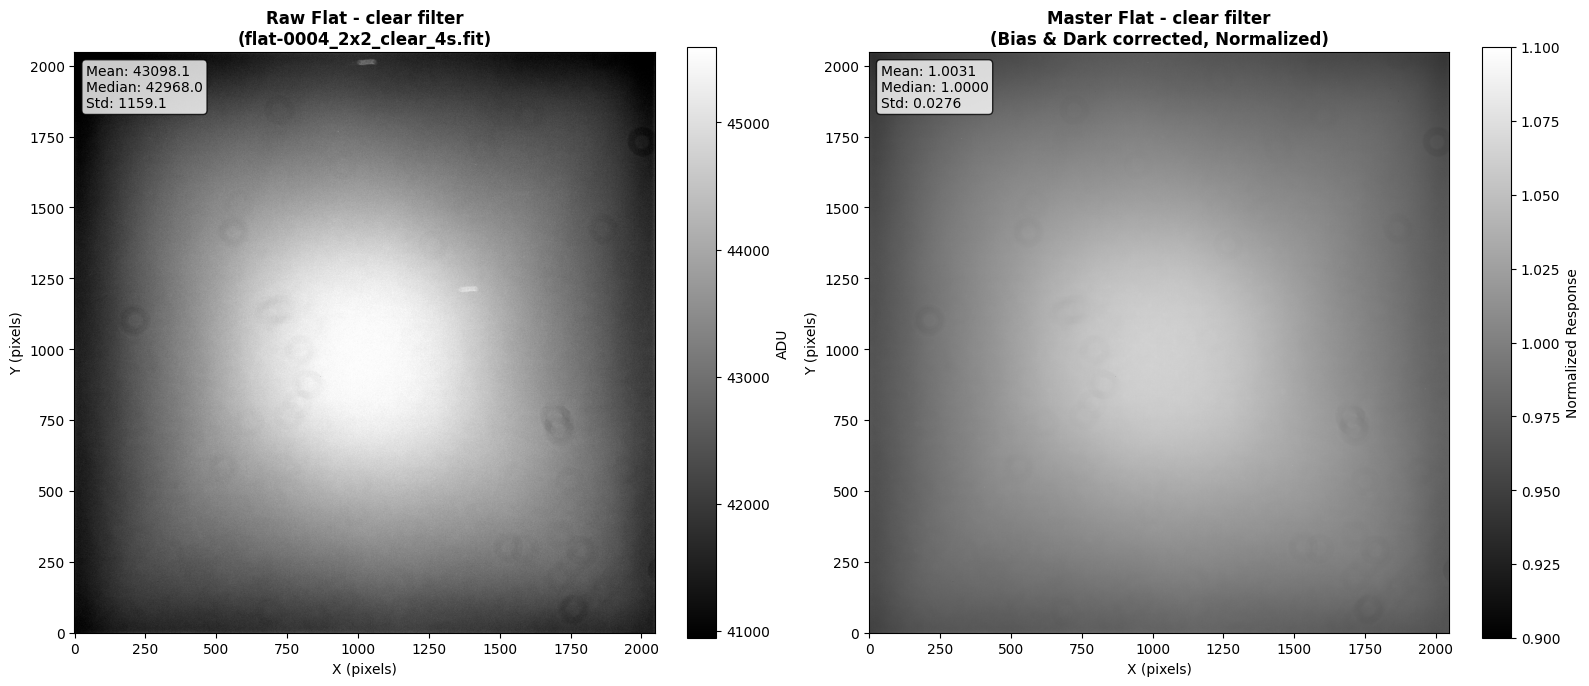

Comparison plot saved as: comparison_flat_clear.png
Processing g filter...


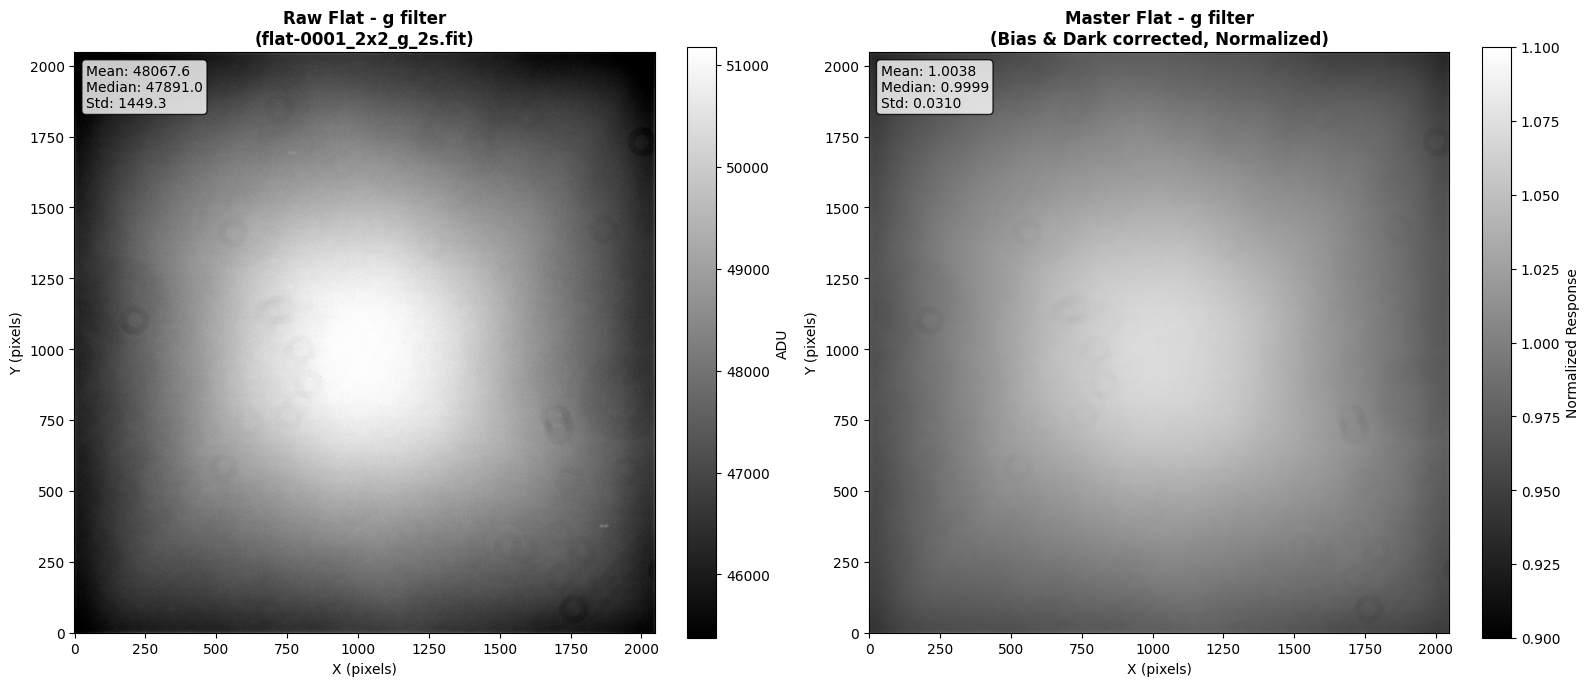

Comparison plot saved as: comparison_flat_g.png
Processing r filter...


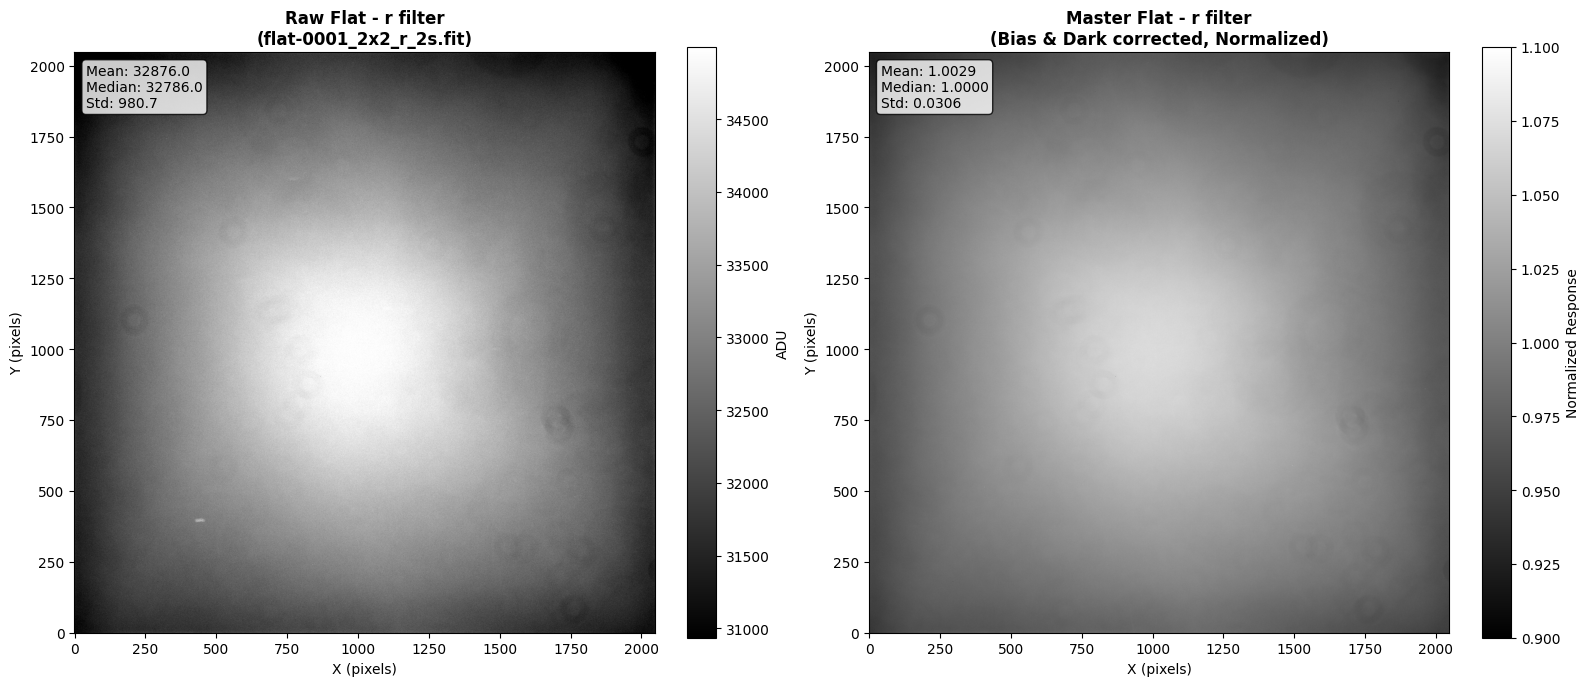

Comparison plot saved as: comparison_flat_r.png
Processing i filter...


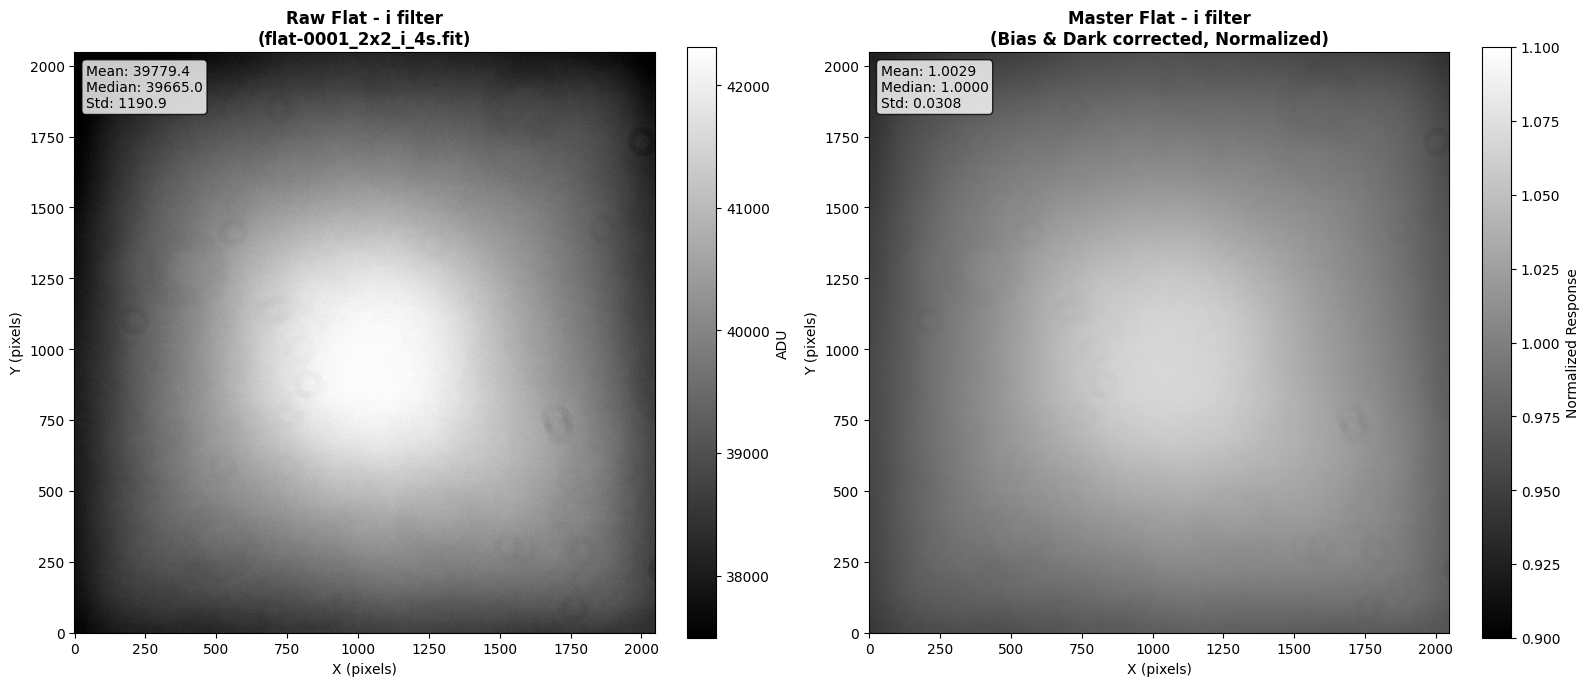

Comparison plot saved as: comparison_flat_i.png

Generating all master flats comparison...


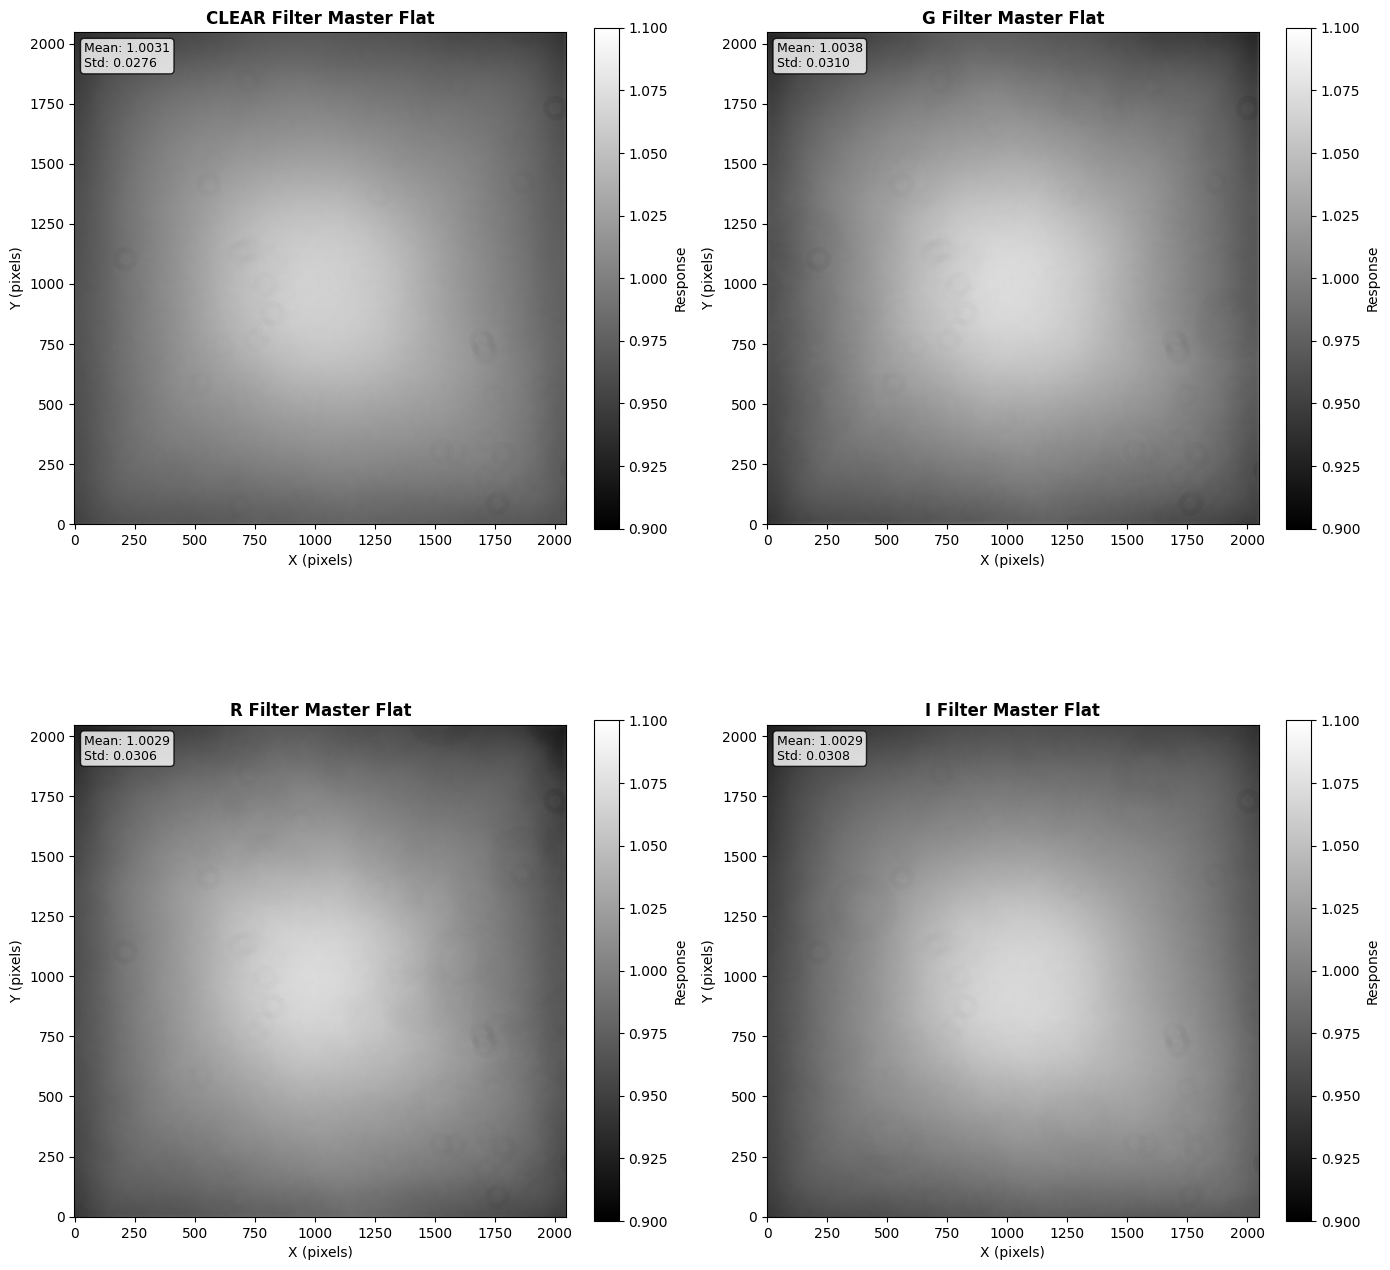

All master flats comparison saved as: all_master_flats.png

Generating profile analysis for clear filter...


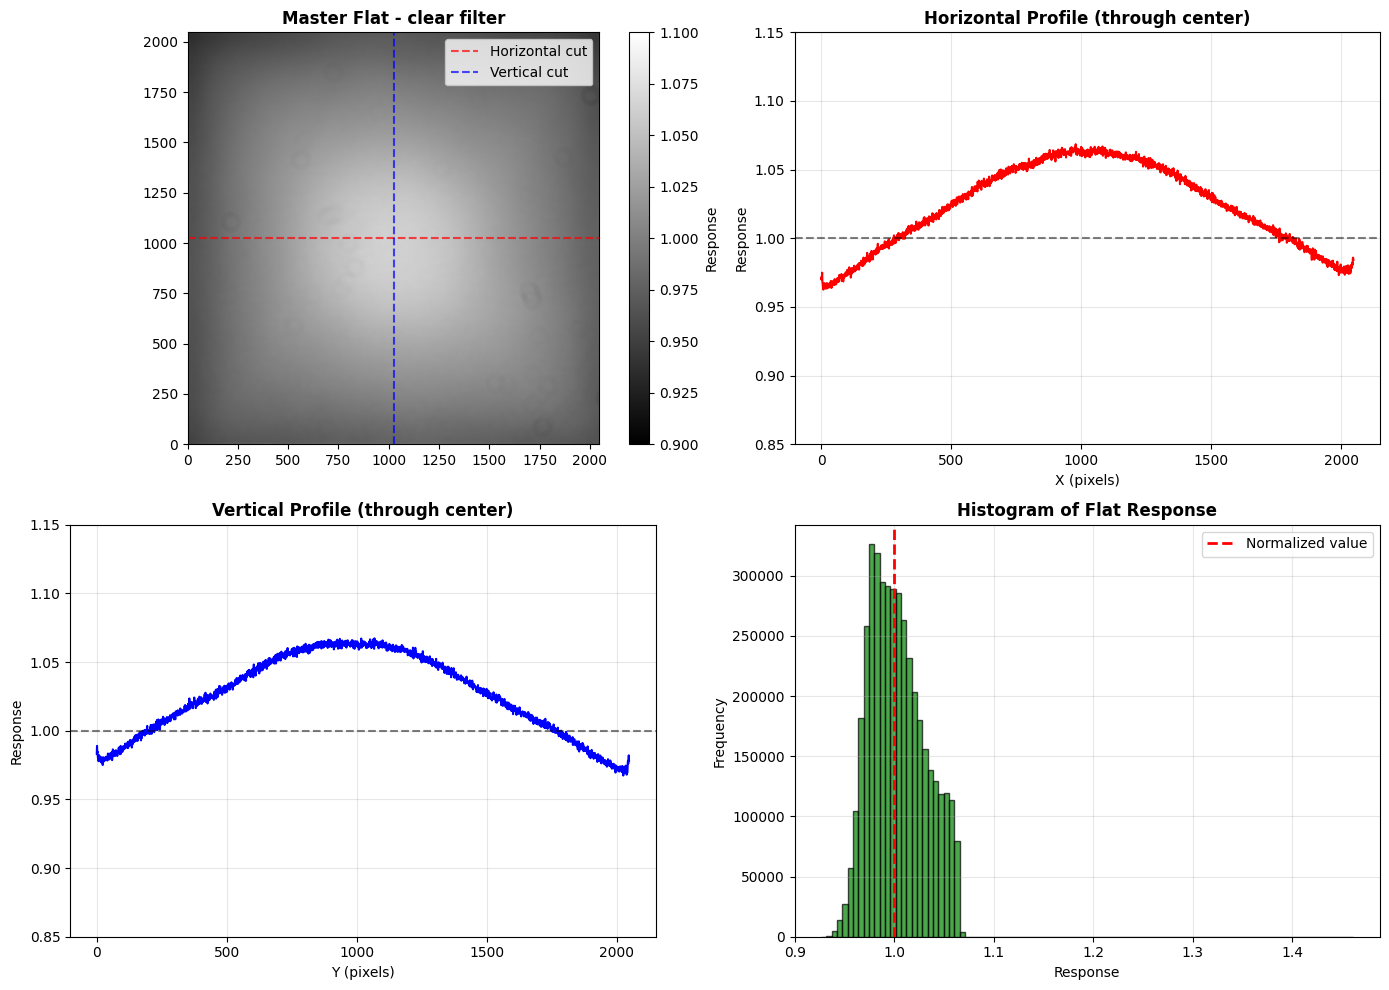

Profile plot saved as: profile_flat_clear.png

All visualizations complete!


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm
import glob

def load_fits(filepath):
    """Load a FITS file and return data."""
    with fits.open(filepath) as hdul:
        return hdul[0].data.astype(np.float32)

def visualize_flats_comparison(raw_flat_pattern, master_flat_path, 
                               filter_name, vmin=None, vmax=None):
    """
    Visualize raw flat vs master flat side by side.
    
    Parameters:
    -----------
    raw_flat_pattern : str
        Glob pattern for raw flat files
    master_flat_path : str
        Path to master flat FITS file
    filter_name : str
        Name of filter for title
    vmin, vmax : float, optional
        Display range limits
    """
    # Load one raw flat (first one found)
    raw_files = sorted(glob.glob(raw_flat_pattern))
    if not raw_files:
        raise ValueError(f"No raw flats found: {raw_flat_pattern}")
    
    raw_flat = load_fits(raw_files[0])
    master_flat = load_fits(master_flat_path)
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Determine color scale limits if not provided
    if vmin is None:
        vmin = np.percentile(raw_flat, 1)
    if vmax is None:
        vmax = np.percentile(raw_flat, 99)
    
    # Plot raw flat
    im1 = axes[0].imshow(raw_flat, cmap='gray', vmin=vmin, vmax=vmax, origin='lower')
    axes[0].set_title(f'Raw Flat - {filter_name} filter\n({raw_files[0].split("/")[-1]})', 
                      fontsize=12, fontweight='bold')
    axes[0].set_xlabel('X (pixels)')
    axes[0].set_ylabel('Y (pixels)')
    plt.colorbar(im1, ax=axes[0], label='ADU', fraction=0.046)
    
    # Add statistics to raw flat
    raw_stats = f'Mean: {np.mean(raw_flat):.1f}\nMedian: {np.median(raw_flat):.1f}\nStd: {np.std(raw_flat):.1f}'
    axes[0].text(0.02, 0.98, raw_stats, transform=axes[0].transAxes,
                fontsize=10, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot master flat (normalized, so use different scale)
    im2 = axes[1].imshow(master_flat, cmap='gray', vmin=0.9, vmax=1.1, origin='lower')
    axes[1].set_title(f'Master Flat - {filter_name} filter\n(Bias & Dark corrected, Normalized)', 
                      fontsize=12, fontweight='bold')
    axes[1].set_xlabel('X (pixels)')
    axes[1].set_ylabel('Y (pixels)')
    plt.colorbar(im2, ax=axes[1], label='Normalized Response', fraction=0.046)
    
    # Add statistics to master flat
    master_stats = f'Mean: {np.mean(master_flat):.4f}\nMedian: {np.median(master_flat):.4f}\nStd: {np.std(master_flat):.4f}'
    axes[1].text(0.02, 0.98, master_stats, transform=axes[1].transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(f'comparison_flat_{filter_name}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Comparison plot saved as: comparison_flat_{filter_name}.png")

def visualize_all_master_flats(master_flats_dir):
    """
    Visualize all master flats in a grid.
    
    Parameters:
    -----------
    master_flats_dir : str
        Directory containing master flat files
    """
    filters = ['clear', 'g', 'r', 'i']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    axes = axes.flatten()
    
    for i, filt in enumerate(filters):
        master_flat_path = f'{master_flats_dir}/master_flat_{filt}.fits'
        
        try:
            master_flat = load_fits(master_flat_path)
            
            im = axes[i].imshow(master_flat, cmap='gray', vmin=0.9, vmax=1.1, origin='lower')
            axes[i].set_title(f'{filt.upper()} Filter Master Flat', fontsize=12, fontweight='bold')
            axes[i].set_xlabel('X (pixels)')
            axes[i].set_ylabel('Y (pixels)')
            plt.colorbar(im, ax=axes[i], label='Response', fraction=0.046)
            
            # Add statistics
            stats = f'Mean: {np.mean(master_flat):.4f}\nStd: {np.std(master_flat):.4f}'
            axes[i].text(0.02, 0.98, stats, transform=axes[i].transAxes,
                        fontsize=9, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
        except Exception as e:
            axes[i].text(0.5, 0.5, f'Error loading {filt} filter:\n{str(e)}',
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{filt.upper()} Filter - Not Found')
    
    plt.tight_layout()
    plt.savefig('all_master_flats.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("All master flats comparison saved as: all_master_flats.png")

def visualize_flat_profile(master_flat_path, filter_name):
    """
    Visualize horizontal and vertical profiles through center of flat.
    
    Parameters:
    -----------
    master_flat_path : str
        Path to master flat FITS file
    filter_name : str
        Name of filter for title
    """
    master_flat = load_fits(master_flat_path)
    
    # Get center profiles
    ny, nx = master_flat.shape
    cy, cx = ny // 2, nx // 2
    
    h_profile = master_flat[cy, :]
    v_profile = master_flat[:, cx]
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Image with lines showing where profiles are taken
    im = axes[0, 0].imshow(master_flat, cmap='gray', vmin=0.9, vmax=1.1, origin='lower')
    axes[0, 0].axhline(cy, color='red', linestyle='--', alpha=0.7, label='Horizontal cut')
    axes[0, 0].axvline(cx, color='blue', linestyle='--', alpha=0.7, label='Vertical cut')
    axes[0, 0].set_title(f'Master Flat - {filter_name} filter', fontweight='bold')
    axes[0, 0].legend()
    plt.colorbar(im, ax=axes[0, 0], label='Response', fraction=0.046)
    
    # Horizontal profile
    axes[0, 1].plot(h_profile, 'r-', linewidth=1.5)
    axes[0, 1].axhline(1.0, color='black', linestyle='--', alpha=0.5)
    axes[0, 1].set_xlabel('X (pixels)')
    axes[0, 1].set_ylabel('Response')
    axes[0, 1].set_title('Horizontal Profile (through center)', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim([0.85, 1.15])
    
    # Vertical profile
    axes[1, 0].plot(v_profile, 'b-', linewidth=1.5)
    axes[1, 0].axhline(1.0, color='black', linestyle='--', alpha=0.5)
    axes[1, 0].set_xlabel('Y (pixels)')
    axes[1, 0].set_ylabel('Response')
    axes[1, 0].set_title('Vertical Profile (through center)', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0.85, 1.15])
    
    # Histogram
    axes[1, 1].hist(master_flat.flatten(), bins=100, color='green', alpha=0.7, edgecolor='black')
    axes[1, 1].axvline(1.0, color='red', linestyle='--', linewidth=2, label='Normalized value')
    axes[1, 1].set_xlabel('Response')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Histogram of Flat Response', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'profile_flat_{filter_name}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Profile plot saved as: profile_flat_{filter_name}.png")


# Example usage
if __name__ == "__main__":
    
    base_path = '/home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19'
    
    # Example 1: Compare raw vs master flat for each filter
    print("Generating raw vs master flat comparisons...\n")
    
    filters_config = {
        'clear': {'raw_pattern': f'{base_path}/FLATclear/*.fit*'},
        'g': {'raw_pattern': f'{base_path}/FLATg/*.fit*'},
        'r': {'raw_pattern': f'{base_path}/FLATr/*.fit*'},
        'i': {'raw_pattern': f'{base_path}/FLATi/*.fit*'}
    }
    
    for filt, config in filters_config.items():
        try:
            print(f"Processing {filt} filter...")
            visualize_flats_comparison(
                raw_flat_pattern=config['raw_pattern'],
                master_flat_path=f'master_flats/master_flat_{filt}.fits',
                filter_name=filt
            )
        except Exception as e:
            print(f"Error processing {filt} filter: {e}")
    
    # Example 2: Show all master flats together
    print("\nGenerating all master flats comparison...")
    visualize_all_master_flats('master_flats')
    
    # Example 3: Show detailed profiles for one filter
    print("\nGenerating profile analysis for clear filter...")
    visualize_flat_profile('master_flats/master_flat_clear.fits', 'clear')
    
    print("\nAll visualizations complete!")